In [140]:
%matplotlib inline

import pandas as pd
import numpy as np
import csv
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from scipy import sparse

import matplotlib.pyplot as plt

airbnb_files = ['data/raw_data/Austin_listings.csv', 'data/raw_data/Boston_listings.csv', 'data/raw_data/Asheville_listings.csv']


In [141]:
def drop_airbnb_cols(filename):
    '''
        input: a filename for detailed airbnb listing data
        output: a pandas dataframe with unecessary columns dropped
    '''
    
    df = pd.read_csv(filename)
    df.drop(['id', 'listing_url', 'scrape_id', 'last_scraped', 'thumbnail_url', 'medium_url', 'picture_url', \
             'xl_picture_url', 'host_id', 'host_url', 'host_thumbnail_url', 'host_picture_url', 'calendar_last_scraped', \
             'weekly_price', 'monthly_price', 'neighbourhood_cleansed', 'license', 'jurisdiction_names', 'square_feet', \
             'neighbourhood', 'calculated_host_listings_count', 'first_review', 'last_review', 'country', 'country_code', \
            'latitude', 'longitude', 'host_name', 'host_location', 'market', 'state', 'city', 'is_location_exact', \
            'smart_location', 'has_availability', 'calendar_updated', 'host_listings_count', 'experiences_offered', \
            'host_since'], axis=1, inplace=True)
    return df


In [142]:
def get_col_names(files):
    '''
        input: a list of detailed airbnb listing data files
        output: a list of common column names (columns that occur in all the files)
    '''
    
    counts = {}
    
    for f in files: 
        for c in drop_airbnb_cols(f).columns: 
            if c in counts: 
                counts[c] += 1
            else: 
                counts[c] = 1

    cols = []
    for c in counts: 
        if counts[c] == len(files):
            cols.append(c)
    
    return cols

In [143]:
def segment(vector, train, dev, test): 
    '''
        Separates a vector into train, dev, and test data in 80%/10%/10% divisions.
    
        input: 
            - a vector of featurized data
            - a list of existing featurized training data
            - a list of existing featurized development data
            - a list of existing featurized testing data
        
        output: 
            - train, dev, and test lists that include the existing featurized dataset (from the input) 
                appended with data from the input vector
    '''
    
    count = len(vector)
    test += vector[-1*int(count*.1):]
    dev += vector[-1*int(count*.2):-1*int(count*.1)]
    train += vector[:int(count*.8)]
    
    return train, dev, test


In [144]:
def featurize(df):
    '''
        old featurize function from milestone 2, will be replaced with individual functions for each col category
    '''
    
    df['price'] = df['price'].map(lambda x: x.replace('$', "").replace(',',"")) # strip $'s and ,'s from the price field
    df[['price']] = df[['price']].apply(pd.to_numeric) # turn the cleaned price col into a number col
    cols = df.columns.tolist()
    cols.remove('price')
    cols = ['price'] + cols # put price as the 0th field in the rows
    df = df[cols]
    
    text_cols = df.select_dtypes(exclude=['float64', 'int64']) # get text fields (naïvely)
    num_cols = df.select_dtypes(include=['float64', 'int64']) # get number fields (naïvely)
    num_cols.fillna(value=0, inplace=True) # fill all NA number fields with 0
    
    return [list(i) for i in num_cols.as_matrix()] # turn matrix of num cols into a list of lists to write to csv file

In [145]:
def featurize_categorical(df):
    df['price'] = df['price'].map(lambda x: x.replace('$', "").replace(',',""))
    df['price'] = df['price'].apply(pd.to_numeric) # turn the price col into a number col
    
    # boolean
    bool_cols = ['require_guest_profile_picture', 'require_guest_phone_verification', 'requires_license', 'instant_bookable']
    bool_map = {'t': 1, 'f': 0}
    for col in bool_cols:
        df[col].replace(bool_map, inplace=True)
    # categorical - rn treating everything else as categorical to simplify things
     # TODO: separate ordinal columns
    categorical_cols = ['bed_type', 'cancellation_policy', 'room_type']
    for col in categorical_cols:
        unique_vals = df[col].unique()
        cat_map = { unique_vals[i]: i for i in range(len(unique_vals)) }
        df[col].replace(cat_map, inplace=True) # slow but ok for now
    v = [list(i) for i in df.as_matrix()]
    return v

In [146]:
def featurize_text(df):
    # TODO: refactor
    df['price'] = df['price'].map(lambda x: x.replace('$', "").replace(',',""))
    df['price'] = df['price'].apply(pd.to_numeric) # turn the price col into a number col
    
    prices = df['price'].tolist()
    X = [[prices[i]] for i in range(len(prices))]
    for col in df.columns:
        if col != 'price':
            corpus = df[col].fillna(value="").values
            vectorizer = CountVectorizer()
            x = vectorizer.fit_transform(corpus) #TODO: clean text
            for i, bow in enumerate(x):
                indices = bow.indices
                num = bow.data
                data = zip(indices, num)
                X[i] += [str(datum[0]) + ':' + str(datum[1]) for datum in data]
    return X

In [147]:
def featurize_num(df): 
    pass

In [148]:
def separate_cols(files): 
    '''
        Separates out the different column types into 3 lists of column names. 
        
        input: list of airbnb data files
        output: a tuple of length three 
    '''

    cols = get_col_names(files)

    label_col = ['price']
    # ones that are never null
    categorical_cols = ['require_guest_profile_picture', 'require_guest_phone_verification', 'requires_license', 'instant_bookable', 'bed_type', 'cancellation_policy', 'room_type']
    num_cols = ['number_of_reviews', 'accommodates', 'minimum_nights', 'maximum_nights', 'guests_included', 'availability_30', 'availability_60', 'availability_90', 'availability_365']
    
    # c nulls to "" 
    text_cols = ['name', 'neighborhood_overview', 'summary', 'transit', 'street', 'host_neighbourhood', 'notes', 'space', 'description']
    
    return label_col+categorical_cols, label_col+num_cols, label_col+text_cols


In [149]:
def save_datasets(col_type, train, dev, test):
    '''
        input: 
            - col_type: categorical, text, num
            - train, dev, and test lists of featurized vectors
            
        Saves 3 csv files: train, dev, and test with col_type prefix
    '''
    
    with open('data/' + col_type + '_train.csv', 'w') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(train)

    with open('data/' + col_type + '_dev.csv', 'w') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(dev)

    with open('data/' + col_type + '_test.csv', 'w') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(test)
        
def save_sparse_datasets(col_type, train, dev, test):
    train_name = 'data/' + col_type + '_train.csv'
    dev_name = 'data/' + col_type + '_dev.csv'
    test_name = 'data/' + col_type + '_test.csv'
    save_sparse_csr(train_name, train)
    save_sparse_csr(dev_name, dev)
    save_sparse_csr(test_name, test)
    
def save_sparse_csr(filename,array):
    print array[:5]
    print type(array)
    array = sparse.csr_matrix(array)
    np.savez(filename,data = array.data ,indices=array.indices,
             indptr =array.indptr, shape=array.shape )
    
def load_sparse_csr(filename):
    loader = np.load(filename)
    return csr_matrix((  loader['data'], loader['indices'], loader['indptr']),
                         shape = loader['shape'])

In [150]:
def create_datasets():
    '''
        Creates train, dev, and test files for each column type (categorical, num, text)
    '''
    
    # this could be cleaned up with a loop for modularity
    
    categorical_train = []
    num_train = []
    text_train = []
    
    categorical_dev = []
    num_dev = []
    text_dev = []
    
    categorical_test = []
    num_test = []
    text_test = []
    
    categorical_cols, num_cols, text_cols = separate_cols(airbnb_files)

    for f in airbnb_files:   
        df = pd.read_csv(f, dtype={'zipcode': 'str'})
        
        categorical_df = df[categorical_cols]
        num_df = df[num_cols]
        text_df = df[text_cols]
        
        categorical_vector = featurize_categorical(categorical_df)
#         num_vector = featurize_num(num_df)
#         text_vector = featurize_text(text_df)

        categorical_train, categorical_dev, categorical_test = segment(categorical_vector, categorical_train, categorical_dev, categorical_test)
#         num_train, num_dev, num_test = segment(num_vector, num_train, num_dev, num_test)
#         text_train, text_dev, text_test = segment(text_vector, text_train, text_dev, text_test)
        
    save_datasets('categorical', categorical_train, categorical_dev, categorical_test)
#     save_datasets('num', num_train, num_dev, num_test)
#     save_sparse_datasets('text', text_train, text_dev, text_test)

In [151]:
create_datasets()

/Users/samanthavoigt/Documents/Wellesley/ML/venv/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/samanthavoigt/Documents/Wellesley/ML/venv/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [152]:
def read_files_to_datasets(train_file, test_file): 
    '''
        Returns x_train, y_train, x_test, y_test
    '''
    
    train_df = pd.read_csv(train_file)
    test_df = pd.read_csv(test_file)
    
    print train_df[:5]
    
    y_train = train_df[train_df.columns[0]].as_matrix()
    x_train = train_df[train_df.columns[1:]].as_matrix()
    y_test = test_df[test_df.columns[0]].as_matrix()
    x_test = test_df[test_df.columns[1:]].as_matrix()
    
    print y_train[:5]
    
    return x_train, y_train, x_test, y_test

In [159]:
def lin_reg(X_train, Y_train, X_test, Y_test): 
    # Create linear regression object
    regr = LinearRegression()

    # Train the model using the training sets
#     regr.fit(np.transpose(np.matrix(X_train)), np.transpose(np.matrix(Y_train)))
    regr.fit(X_train, Y_train)

    # The coefficients
    print('Coefficients: \n', regr.coef_)
    # The mean squared error
    print("Mean squared error: %.2f"
          % np.mean((regr.predict(X_test) - Y_test) ** 2))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % regr.score(X_test, Y_test))
    
    plt.scatter(Y_test, regr.predict(X_test))
    plt.xlim(0,500)
    plt.xlabel("Prices")
    plt.ylabel("Predicted Prices")
    plt.title("Prices vs. Predicted Prices")

   300.0  0.0  0.0.1  0.0.2  0.0.3  0.0.4  0.0.5  0.0.6
0   99.0  0.0    0.0    0.0    0.0    1.0    0.0    0.0
1  100.0  0.0    0.0    0.0    0.0    0.0    1.0    0.0
2  100.0  0.0    0.0    0.0    0.0    0.0    1.0    0.0
3  599.0  0.0    0.0    0.0    0.0    0.0    2.0    1.0
4  100.0  0.0    0.0    0.0    0.0    0.0    1.0    0.0
[  99.  100.  100.  599.  100.]
('Coefficients: \n', array([ -1.00924614e+02,   4.16242532e+01,   3.32386174e-14,
        -6.10964714e+01,  -6.51429516e+01,   4.17209698e+01,
         9.10076749e+01]))
Mean squared error: 109382.89
Variance score: 0.05


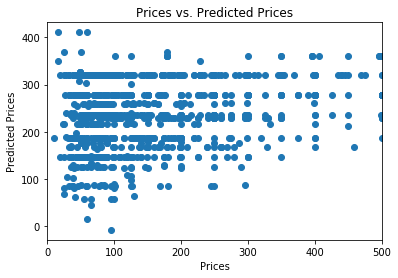

In [160]:
x_train, y_train, x_test, y_test = read_files_to_datasets('data/categorical_train.csv', 'data/categorical_test.csv')
lin_reg(x_train, y_train, x_test, y_test)